### Content Analysis Political Pages - Crime Posts
### Topic Modeling 

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

## 1. Reads  Info
Reads the information from all the posts from the studied period

In [3]:
import os
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [4]:

#path = "Latinx2020/"
posts = pd.read_csv("political/Topics_FB_Political_Posts_per_partycrime.csv")
#We rename the colum Page Name to be able to concat with Group Posts
posts.rename(columns={'Page Name':'Group Name'}, inplace=True)
posts.shape

(1021, 35)

In [5]:

posts.shape

(1021, 35)

In [6]:
posts['URL']

0       https://www.facebook.com/latinosvstrump/posts/...
1       https://www.facebook.com/latinosvstrump/posts/...
2       https://www.facebook.com/latinosvstrump/posts/...
3       https://www.facebook.com/LatinosforJoe/posts/5...
4       https://www.facebook.com/LatinosforJoe/posts/5...
                              ...                        
1016    https://www.facebook.com/groups/16256741844186...
1017    https://www.facebook.com/groups/16256741844186...
1018    https://www.facebook.com/groups/16256741844186...
1019    https://www.facebook.com/groups/16256741844186...
1020    https://www.facebook.com/groups/16256741844186...
Name: URL, Length: 1021, dtype: object

## 9. Filter the most relevant columns
### Add column to concat Message, Description, Link Text

In [7]:
concat_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('') + (' ' + posts['Link']).fillna('')
posts['MessageDescr'] = concat_message

concat_just_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('')
posts['MessageOnly'] = concat_just_message

In [8]:
posts.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions', 'Overperforming Score', 'MessageDescr',
       'MessageOnly', 'party'],
      dtype='object')

In [9]:
posts["Created"].head(5)

0    2020-11-01 13:53:23 EST
1    2020-08-31 07:01:40 EDT
2    2020-08-24 17:31:10 EDT
3    2020-08-27 17:01:14 EDT
4    2020-08-29 23:06:22 EDT
Name: Created, dtype: object

In [10]:
posts['converted_date'] = pd.to_datetime(posts["Created"])
posts['converted_date']

0      2020-11-01 13:53:23-05:00
1      2020-08-31 07:01:40-04:00
2      2020-08-24 17:31:10-04:00
3      2020-08-27 17:01:14-04:00
4      2020-08-29 23:06:22-04:00
                  ...           
1016   2020-09-12 07:09:22-04:00
1017   2020-09-08 18:59:03-04:00
1018   2020-09-06 23:24:07-04:00
1019   2020-09-03 23:28:48-04:00
1020   2020-08-29 20:15:43-04:00
Name: converted_date, Length: 1021, dtype: datetime64[ns, tzlocal()]

In [11]:
posts['converted_date']=posts['converted_date'].dt.date

In [12]:
import seaborn as sns
pd.set_option('display.max_rows', None)
group_date = posts.groupby('converted_date').agg({'Facebook Id':'count'}).reset_index().rename(columns={'Facebook Id':'count'})
group_date


,converted_date,count
0,2020-08-18,11
1,2020-08-19,8
2,2020-08-20,8
3,2020-08-21,9
4,2020-08-22,11
5,2020-08-23,10
6,2020-08-24,11
7,2020-08-25,17
8,2020-08-26,17
9,2020-08-27,13


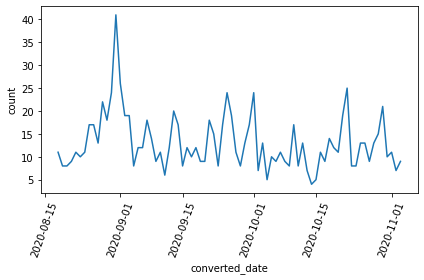

In [13]:
sns.lineplot(data=group_date, x='converted_date', y='count')
plt.xticks(rotation=70)
plt.tight_layout()

In [14]:
posts[posts['Link Text'].str.lower().str.contains("í", na = False)].head(1)

,Unnamed: 0,Group Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,...,Link Text,Description,Sponsor Id,Sponsor Name,Total Interactions,Overperforming Score,MessageDescr,MessageOnly,party,converted_date
2,261,Latinos Contra Trump,latinosvstrump,1161597243956409,229790.0,2020-08-24 17:31:10 EDT,Link,22,56,44,...,Video Muestra a la Policía de Kenosha Disparan...,Las protestas estallaron inmediatamente en tod...,NaN,NaN,226,-1.37,"Tantos meses de protesta, de lucha en las call...","Tantos meses de protesta, de lucha en las call...",Democrat,2020-08-24


In [15]:
#!/usr/bin/env python
import re

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          
                           "]+", flags = re.UNICODE)
    
    
    return regrex_pattern.sub(r'',text)

print(deEmojify(text))

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

This is a smiley face 😂
This is a smiley face 


In [16]:

posts['Group Name']=posts['Group Name'].apply(deEmojify)
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace('"', ''))
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace(',', ''))
posts['Facebook Id'] = posts['Facebook Id'].astype(int)



### 4. US states

In [17]:
us_states = pd.DataFrame({'State':['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','District of Columbia','Florida',
             'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
             'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
             'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina',
             'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']})

## 3. Which groups are publishing the majority of the content

In [18]:
group = posts.groupby(['Group Name'])
final_groups = group.agg({'Facebook Id':'count'}).sort_values(by='Facebook Id',ascending=False)
final_groups

,Facebook Id
Group Name,
DONALD TRUMP PARA HISPANOS,124
Latinos For Trump -California Group,123
Mexicans for Donald Trump,68
CARA - Cuban American Republican Alliance,61
Latinos For Trump.,55
Republican National Hispanic Assembly - Official Group,46
Latinos Against Donald Trump,43
Arizona Latino Republican Association,38
Puertorican Republican and Latin Conservative Movement,28


## Tokenize words and Clean-up text

In [19]:
content = posts.copy()
content.drop_duplicates(subset= ['MessageDescr'], inplace=True)
content['MessageDescr']

0       Esto es asqueroso, indignante. Sobre todo porq...
1       "Quieres que yo detenga la violencia que tú ay...
2       Tantos meses de protesta, de lucha en las call...
3       Just when you think it can't get worse. https:...
4       Biden doing what he does best. https://www.was...
5       Biden comes out punching! https://www.nbcnews....
6       It's a legitimate question. https://www.cnn.co...
7       Trump knew COVID-19 was lethal and he intentio...
8       Trump needs women in the suburbs but this arti...
9       The coronavirus is no hoax! Trump sucks for do...
11      He was a leader on VAWA and it is such an impo...
12      ¿Cacería de negros en una moneda? No, el probl...
14      Trump tried as hard as he could to distract th...
15      No estamos hablando de un tipo cualquiera, se ...
16      The lying just never ends. https://www.cnn.com...
18      Why would you say this? https://thehill.com/ho...
19      Are you all ready for the debate? How should B...
20      The fa

In [20]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(906,)

In [21]:
# Convert to list
data = content.cleanMessage.tolist()

In [22]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [23]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['esto', 'es', 'asqueroso', 'indignante', 'sobre', 'todo', 'porque', 'la', 'policia', 'se', 'nego', 'intervenir', 'hay', 'que', 'denunciarlo', 'el', 'equipo', 'de', 'biden', 'se', 'vio', 'obligado', 'cancelar', 'varios', 'eventos', 'de', 'la', 'campana', 'de', 'texas', 'despues', 'de', 'una', 'terrible', 'demostracion', 'de', 'violencia', 'de', 'los', 'matones', 'de', 'trump', 'video', 'muestra', 'matones', 'de', 'trump', 'embistiendo', 'auto', 'de', 'empleado', 'de', 'biden', 'hostigando', 'al', 'autobus', 'de', 'la', 'campana'], ['quieres', 'que', 'yo', 'detenga', 'la', 'violencia', 'que', 'tu', 'ayudaste', 'crear', 'lo', 'que', 'eeuu', 'necesita', 'es', 'que', 'te', 'detengan', 'ti', 'para', 'que', 'podamos', 'volver', 'unirnos', 'como', 'pais', 'el', 'alcalde', 'ted', 'wheeler', 'puso', 'la', 'responsabilidad', 'de', 'la', 'muerte', 'de', 'ayer', 'de', 'lleno', 'en', 'el', 'lugar', 'que', 'le', 'correspondia', 'valiente', 'firme', 'el', 'alcalde', 'de', 'portland', 'culpa', 'trump

#### Creating Bigram and Trigram Models

In [24]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['esto', 'es', 'asqueroso', 'indignante', 'sobre', 'todo', 'porque', 'la', 'policia', 'se', 'nego', 'intervenir', 'hay', 'que', 'denunciarlo', 'el', 'equipo', 'de', 'biden', 'se', 'vio', 'obligado', 'cancelar', 'varios', 'eventos', 'de', 'la', 'campana', 'de', 'texas', 'despues', 'de', 'una', 'terrible', 'demostracion', 'de', 'violencia', 'de', 'los', 'matones', 'de', 'trump', 'video', 'muestra', 'matones', 'de', 'trump', 'embistiendo', 'auto', 'de', 'empleado', 'de', 'biden', 'hostigando', 'al', 'autobus', 'de', 'la', 'campana']


## Remove Stopwords, Make Bigrams and Lemmatize

In [25]:
#import nltk
#nltk.download('stopwords')
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much','\ufeff1'])

In [26]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [27]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon
#!python3 -m spacy download es_core_news_sm
#!python3 -m spacy download en
nlp = spacy.load('es', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [28]:
data_lemmatized[0]

['asqueroso',
 'indignante',
 'policia',
 'nego',
 'intervenir',
 'denunciarlo',
 'equipar',
 'ver',
 'obligar',
 'cancelar',
 'evento',
 'despues',
 'terrible',
 'violencia',
 'matón',
 'trump',
 'mostrar',
 'matón',
 'embestir',
 'auto',
 'emplear',
 'biden',
 'hostigar',
 'autobus',
 'campana']

In [29]:
print(data_words_nostops[1:2])

[['quieres', 'detenga', 'violencia', 'ayudaste', 'crear', 'eeuu', 'necesita', 'detengan', 'podamos', 'volver', 'unirnos', 'pais', 'alcalde', 'ted', 'wheeler', 'puso', 'responsabilidad', 'muerte', 'ayer', 'lleno', 'lugar', 'correspondia', 'valiente', 'firme', 'alcalde', 'portland', 'culpa', 'trump', 'devastadora', 'violencia', 'maga']]


## Bag of Words

In [30]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [31]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [32]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)
final_dict = combine_words('president','presidente',count_words)
final_dict = combine_words('democrat','democrats',count_words)
final_dict = combine_words('informacion','informar',count_words)
final_dict = combine_words('covid','coronavirus',count_words)
final_dict = combine_words('democrat / democrats','democratas',count_words)

In [33]:
final_dict.most_common(1000)

[('donald / trump', 740),
 ('american / america / americans', 165),
 ('president / presidente', 163),
 ('decir', 128),
 ('violencia', 114),
 ('democrats', 112),
 ('hacer', 87),
 ('federal', 87),
 ('partir', 80),
 ('votar', 75),
 ('political', 66),
 ('country', 63),
 ('personar', 58),
 ('also', 57),
 ('ley', 55),
 ('hoy', 55),
 ('querer', 54),
 ('izquierdo', 54),
 ('ano', 51),
 ('poder', 50),
 ('usar', 50),
 ('medio', 50),
 ('debatir', 49),
 ('ninos', 48),
 ('ver', 47),
 ('democratas', 47),
 ('armar', 46),
 ('ahora', 45),
 ('grupo', 45),
 ('dar', 45),
 ('ciudad', 43),
 ('order', 42),
 ('tambien', 42),
 ('nuevo', 40),
 ('states', 40),
 ('really', 39),
 ('social', 38),
 ('gente', 38),
 ('post', 38),
 ('apoyar', 38),
 ('solo', 38),
 ('pasar', 38),
 ('cubano', 38),
 ('crear', 37),
 ('vida', 37),
 ('ser', 37),
 ('socialista', 37),
 ('virus', 36),
 ('control', 36),
 ('bien', 35),
 ('crimen', 35),
 ('legal', 35),
 ('comunista', 35),
 ('grande', 34),
 ('national', 34),
 ('ir', 34),
 ('tratar', 

In [34]:
docs = ([' '.join(ele) for ele in data_lemmatized] )


In [35]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
#word_count_vector.toarray()

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(word_count_vector.toarray())

# Map the column names to vocabulary 
bow_df.columns = cv.get_feature_names()

# Print bow_df
#print(bow_df)

In [36]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [37]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
trump,2.288682
america,3.128011
violencia,3.332806
democrats,3.466337
federal,3.699269
political,3.878317
decir,3.878317
country,3.898119
presidente,3.898119
also,3.918322


In [38]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [39]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
matón,0.444678
asqueroso,0.222339
embestir,0.222339
autobus,0.222339
cancelar,0.222339
denunciarlo,0.222339
nego,0.209672
indignante,0.209672
hostigar,0.209672
equipar,0.200684


In [40]:
pd.set_option('display.max_colwidth',None)
#word = df.index[8]
word = r"\b(evento)\b"
content["lowercase"] = content['MessageOnly'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]
word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')

word_messages

/home/claudia/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


unique_messages  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

### Repeated messages

In [41]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr','Link']).aggregate({'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results.rename(columns={"MessageDescr": "Counts"}, inplace=True)

#results.to_csv("mostpopularNewsMedia.csv")

In [42]:
##results.sort_values(by='Counts',ascending=False)

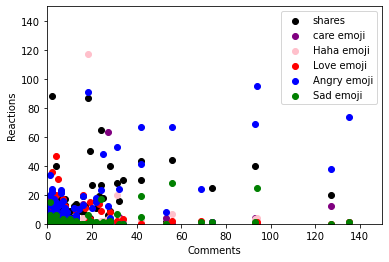

In [43]:
results.reset_index()
plt.xlim(0,150)
plt.ylim(0,150)

plt.xlabel('Comments')
plt.ylabel('Reactions')
plt.scatter(results.Comments, results.Shares,c='black',label='shares')
plt.scatter(results.Comments, results.Haha,c='purple',label='care emoji')
plt.scatter(results.Comments, results.Wow,c='pink',label='Haha emoji')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')

plt.legend()


## Topic Modeling
### Create the Dictionary and Corpus needed for Topic Modeling

In [44]:


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)]]


[[('asqueroso', 1),
  ('auto', 1),
  ('autobus', 1),
  ('biden', 1),
  ('campana', 1),
  ('cancelar', 1),
  ('denunciarlo', 1),
  ('despues', 1),
  ('embestir', 1),
  ('emplear', 1),
  ('equipar', 1),
  ('evento', 1),
  ('hostigar', 1),
  ('indignante', 1),
  ('intervenir', 1),
  ('matón', 2),
  ('mostrar', 1),
  ('nego', 1),
  ('obligar', 1),
  ('policia', 1),
  ('terrible', 1),
  ('trump', 1),
  ('ver', 1),
  ('violencia', 1)]]

## Buiding the Topic Model

In [45]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [46]:
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.039*"crisis" + 0.031*"individual" + 0.027*"chaos" + 0.020*"http" + '
  '0.016*"usar" + 0.016*"reform" + 0.016*"global" + 0.016*"create" + '
  '0.015*"domestic_violence" + 0.013*"regional"'),
 (1,
  '0.074*"country" + 0.068*"side" + 0.055*"provide" + 0.049*"medicinar" + '
  '0.048*"made" + 0.040*"social" + 0.030*"race" + 0.030*"donar" + '
  '0.028*"criminal" + 0.026*"possible"'),
 (2,
  '0.000*"escasez" + 0.000*"embaucar" + 0.000*"madurar" + 0.000*"instaurar" + '
  '0.000*"ingenuidad" + 0.000*"impunidad" + 0.000*"impostor" + 0.000*"gato" + '
  '0.000*"gallardia" + 0.000*"oficialista"'),
 (3,
  '0.080*"law" + 0.075*"accused" + 0.058*"ahora" + 0.046*"ciudad" + '
  '0.044*"gente" + 0.042*"grande" + 0.033*"despues" + 0.032*"historia" + '
  '0.024*"odiar" + 0.022*"intentar"'),
 (4,
  '0.345*"democrats" + 0.126*"pandemic" + 0.087*"states" + 0.007*"inside" + '
  '0.004*"importance" + 0.000*"ones" + 0.000*"riots" + 0.000*"course" + '
  '0.000*"sides" + 0.000*"personal"'),
 (5,
  '0.15

## Compute Model Perplexity and Coherence Score

In [47]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -20.541969805258194

Coherence Score:  0.4681058670045698


## Visualize the topics-keywords

In [48]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.074805 -0.348863       1        1  22.674068
19    -0.010689 -0.016947       2        1  14.831673
9     -0.407166  0.082085       3        1  13.484931
3      0.019771  0.015623       4        1   7.847795
1     -0.020471  0.033163       5        1   7.336143
10     0.028588  0.020543       6        1   6.437894
11     0.022676  0.032724       7        1   4.618222
7      0.033041  0.019071       8        1   3.797636
0      0.028980 -0.024516       9        1   3.160973
18     0.036881  0.020525      10        1   2.535944
16     0.029476  0.019287      11        1   2.445529
5      0.038135  0.019551      12        1   2.162418
4      0.018415  0.028879      13        1   1.799761
12     0.038776  0.017700      14        1   1.546749
13     0.037378  0.015749      15        1   1.452626
17     0.037678  0.016516      16        1   1.429893
15     0.036507  0.009685      17        1   1.341532
8      0.037869  0.017115      18        1   0.685682
14     0.035072  0.011866      19        1   0.297695
2      0.033888  0.010244      20        1   0.112829, topic_info=                      Term         Freq        Total Category  logprob  \
21                   trump  1421.000000  1421.000000  Default  30.0000   
138                america   399.000000   399.000000  Default  29.0000   
119                  decir   453.000000   453.000000  Default  28.0000   
132             presidente   348.000000   348.000000  Default  27.0000   
309              democrats   125.000000   125.000000  Default  26.0000   
81                   hacer   184.000000   184.000000  Default  25.0000   
376                    two   143.000000   143.000000  Default  24.0000   
23               violencia   337.000000   337.000000  Default  23.0000   
64                   virus   114.000000   114.000000  Default  22.0000   
265              political    98.000000    98.000000  Default  21.0000   
172                 mexico   134.000000   134.000000  Default  20.0000   
378                    law   126.000000   126.000000  Default  19.0000   
136                accused   118.000000   118.000000  Default  18.0000   
147                   also    80.000000    80.000000  Default  17.0000   
68                 country   109.000000   109.000000  Default  16.0000   
358                  medio   151.000000   151.000000  Default  15.0000   
238               national    67.000000    67.000000  Default  14.0000   
80                     ano    94.000000    94.000000  Default  13.0000   
332                   side   100.000000   100.000000  Default  12.0000   
113                  votar    75.000000    75.000000  Default  11.0000   
356              izquierdo   134.000000   134.000000  Default  10.0000   
302                  order   124.000000   124.000000  Default   9.0000   
114                  ahora    91.000000    91.000000  Default   8.0000   
165                federal    61.000000    61.000000  Default   7.0000   
426                provide    81.000000    81.000000  Default   6.0000   
35                   poder   154.000000   154.000000  Default   5.0000   
22                     ver    60.000000    60.000000  Default   4.0000   
365              preguntar   111.000000   111.000000  Default   3.0000   
37                  querer   149.000000   149.000000  Default   2.0000   
87                  tratar    72.000000    72.000000  Default   1.0000   
119                  decir   452.191040   453.367371   Topic1  -2.3022   
23               violencia   336.175537   337.351868   Topic1  -2.5987   
35                   poder   153.703064   154.879456   Topic1  -3.3813   
37                  querer   147.890259   149.066650   Topic1  -3.4199   
26                   crear   128.849884   130.026276   Topic1  -3.5577   
52                   nuevo   125.763252   126.939613   Topic1  -3.5819   
275                 apoyar   10

## Building LDA Mallet Model

In [49]:
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [50]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
from gensim.models.wrappers import LdaMallet


In [51]:
mallet_path = '/home/claudia/Documents/Latinx2020/mallet-2.0.8/bin/mallet' # update this path

In [52]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [53]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(16,
  [('decir', 0.05772811918063315),
   ('presidente', 0.049348230912476726),
   ('apoyar', 0.0260707635009311),
   ('tiempo', 0.025139664804469275),
   ('vez', 0.019553072625698324),
   ('violencia', 0.0186219739292365),
   ('representante', 0.017690875232774673),
   ('claro', 0.0148975791433892),
   ('querer', 0.0148975791433892),
   ('mejor', 0.0148975791433892)]),
 (7,
  [('hoy', 0.02286902286902287),
   ('vivir', 0.02286902286902287),
   ('gente', 0.022176022176022176),
   ('llamar', 0.021483021483021482),
   ('partir', 0.02079002079002079),
   ('hacer', 0.019404019404019403),
   ('querer', 0.017325017325017324),
   ('socialista', 0.017325017325017324),
   ('llevar', 0.01386001386001386),
   ('historia', 0.013167013167013167)]),
 (15,
  [('chaos', 0.031205673758865248),
   ('crisis', 0.02553191489361702),
   ('federal', 0.024113475177304965),
   ('mexico', 0.02127659574468085),
   ('law', 0.019858156028368795),
   ('global', 0.019858156028368795),
   ('honor', 0.01985815602836

## Finding the optimal number of topics for LDA

In [54]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [55]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

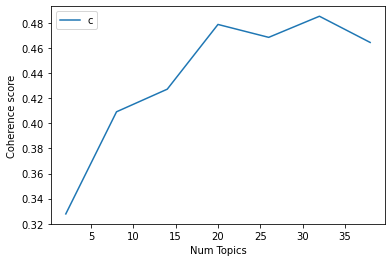

In [56]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [57]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3278
Num Topics = 8  has Coherence Value of 0.4093
Num Topics = 14  has Coherence Value of 0.4273
Num Topics = 20  has Coherence Value of 0.4789
Num Topics = 26  has Coherence Value of 0.4686
Num Topics = 32  has Coherence Value of 0.4855
Num Topics = 38  has Coherence Value of 0.4646


In [63]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.037*"hacer" + 0.036*"democratas" + 0.022*"prensar" + 0.016*"coser" + '
  '0.016*"vandalismo" + 0.016*"corrupto" + 0.014*"palabra" + 0.013*"ley" + '
  '0.013*"grupo" + 0.012*"generar"'),
 (1,
  '0.027*"partir" + 0.027*"gente" + 0.023*"vivir" + 0.020*"dar" + '
  '0.018*"grande" + 0.015*"verdad" + 0.015*"hacer" + 0.015*"querer" + '
  '0.014*"llamar" + 0.014*"socialista"'),
 (2,
  '0.031*"pasar" + 0.029*"unir" + 0.022*"solo" + 0.022*"electoral" + '
  '0.021*"grupo" + 0.016*"esperar" + 0.016*"estadounidense" + 0.015*"marxista" '
  '+ 0.013*"fraude" + 0.013*"terrorista"'),
 (3,
  '0.148*"democrats" + 0.034*"virus" + 0.032*"control" + 0.030*"criminal" + '
  '0.028*"total" + 0.024*"defense" + 0.023*"placer" + 0.020*"legal" + '
  '0.020*"provide" + 0.016*"potential"'),
 (4,
  '0.048*"police" + 0.046*"liberal" + 0.043*"black_male" + 0.040*"officer" + '
  '0.037*"didnt" + 0.034*"race" + 0.034*"medio" + 0.027*"riots" + 0.013*"days" '
  '+ 0.013*"cover"'),
 (5,
  '0.041*"ninos" + 0.034*"p

## Finding the dominant topic in each sentence

In [64]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.0911,"ninos, poder, vida, ser, creer, familia, hijo, tratar, ir, padre","Esto es asqueroso, indignante. Sobre todo porque la policía se negó a intervenir. Hay que denunciarlo... El equipo de Biden se vio obligado a cancelar varios eventos de la campaña de Texas después de una terrible demostración de violencia de los matones de Trump. Video Muestra a Matones de Trump Embistiendo Auto de Empleado de Biden y Hostigando al Autobús de la Campaña"
1,1,13.0,0.0915,"violencia, federal, ciudad, policia, decir, protestar, alcalde, disturbio, violento, propiedad","""Quieres que yo detenga la violencia que tú ayudaste a crear. Lo que EEUU necesita es que te detengan a tí, para que podamos volver a unirnos como país""... El alcalde Ted Wheeler puso la responsabilidad de la muerte de ayer de lleno en el lugar que le correspondía. Valiente y Firme: El Alcalde de Portland Culpa a Trump de la Devastadora Violencia del MAGA"
2,2,13.0,0.1516,"violencia, federal, ciudad, policia, decir, protestar, alcalde, disturbio, violento, propiedad","Tantos meses de protesta, de lucha en las calles y de nuevo esto. Pareciera que no hemos logrado nada... Las protestas estallaron inmediatamente en todo Wisconsin en el aire de la última demostración espantosa de violencia policial. Video Muestra a la Policía de Kenosha Disparando 7 Veces a un Hombre Negro por la Espalda Mientras sus Hijos Miran"
3,3,0.0,0.0500,"hacer, democratas, prensar, coser, vandalismo, corrupto, palabra, ley, grupo, generar",Just when you think it cant get worse.
4,4,0.0,0.0500,"hacer, democratas, prensar, coser, vandalismo, corrupto, palabra, ley, grupo, generar",Biden doing what he does best.
5,5,18.0,0.0686,"cubano, personar, siempre, ver, crimen, gran, poblar, traidor, medio, perder",Biden comes out punching!
6,6,0.0,0.0500,"hacer, democratas, prensar, coser, vandalismo, corrupto, palabra, ley, grupo, generar",Its a legitimate question.
7,7,3.0,0.0673,"democrats, virus, control, criminal, total, defense, placer, legal, provide, potential","Trump knew COVID-19 was lethal and he intentionally downplayed it to deceive the nation! He needs to be held accountable for the deplorable job he’s done to stop the virus, and for the crime he’s committed against American families whose loved one’s had to suffer a desolate death!🤬 Trump knew it was worse than the flu. Trump knew coronavirus was deadly. #TrumpKnew and he did nothing. The Lincoln Project"
8,8,14.0,0.0652,"votar, country, donar, people, states, color, dangerous, choose, city, decidir",Trump needs women in the suburbs but this article suggests he may have already lost them.
9,9,14.0,0.0792,"votar, country, donar, people, states, color, dangerous, choose, city, decidir","The coronavirus is no hoax! Trump sucks for downplaying the magnitude of the pandemic. No plan on reopening schools and businesses, spreading lies about Biden and sparking violence throughout the country! Don’t be deceived by Trump, he’s responsible for far more harm, division and death than good, unity or life. Please wear a mask in public and social distance.✊🏼😷 Melissa Paez-Villarreal, who tested positive for COVID-19, covers a cough in July. Latinos have been disproportionately affected by COVID-19, a reality that reflects a lack of health care and greater potential exposure as essential workers. Latinos, Black people bear brunt of COVID - San Antonio Express, 8/30/2020"


## Find the most representative document for each topic

In [65]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', 400)
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4695,"hacer, democratas, prensar, coser, vandalismo, corrupto, palabra, ley, grupo, generar","POR LA SALVACION DE LOS ESTADOS UNIDOS DE NORTEAMERICA DEL COMUNISMO, SOCIALISMO, LIBERALISMO Y VANDALISMO OCIOSO! DONALD TRUMP A LA PRESIDENCIA PARA SIEMPRE! Mientras los demócratas son los demonios que quieren implantar el liberalismo corrupto, coludiendose con la prensa corrupta, donde por ejemplo CNN no tiene verguenza de mentir y promover la corrupción, mientras que bajo el concepto de di..."
1,1.0,0.7437,"partir, gente, vivir, dar, grande, verdad, hacer, querer, llamar, socialista","Soy ciudadana americana de origen nicaragüense, por la Gracia De Dios, vivo en la ciudad de Miami, Florida hoy quiero compartir con ustedes un tema muy allegado a mi corazón que sangra día a día por que lo está viviendo mi país natal NICARAGUA y no quiero que se llegue a vivir en este hermoso país, que me acogió y al que agradezco, amo y respeto... los nicaragüenses celebramos en septiembre e..."
2,2.0,0.3838,"pasar, unir, solo, electoral, grupo, esperar, estadounidense, marxista, fraude, terrorista","𝐄𝐱𝐢𝐠𝐞𝐧 𝐫𝐞𝐧𝐮𝐧𝐜𝐢𝐚 𝐝𝐞 𝐀𝐥𝐦𝐚𝐠𝐫𝐨 𝐞𝐧 𝐎𝐄𝐀 𝐩𝐨𝐫 𝐠𝐨𝐥𝐩𝐞 𝐞𝐧 𝐁𝐨𝐥𝐢𝐯𝐢𝐚 𝐞𝐧 𝐞𝐥 𝟐𝟎𝟏𝟗 𝙋𝙤𝙧 𝙧𝙚𝙫𝙞𝙨𝙩𝙖 𝙇𝙞𝙗𝙚𝙧𝙩𝙖𝙙 (𝙋𝙚𝙧𝙪́) ᴿᵉᵈᵃᶜᶜⁱᵒ́ⁿ⠘ ²⁴ ᵈᵉ ᵒᶜᵗᵘᵇʳᵉ⸴ ²⁰²⁰ El triunfo del partido Movimiento Al Socialismo (MAS) que lidera Evo Morales, con candidatos como Luis Arce a la presidencia y David Choquehuanca, vicepresidencia, con más del 52%, en las últimas elecciones presidenciales, confirma que no hubo fraude electoral en Boli..."
3,3.0,0.3827,"democrats, virus, control, criminal, total, defense, placer, legal, provide, potential","THE ′′ ALMOST ′′ THIRD (AND LAST) WORLD WAR October 1962. The beautiful island of #Cuba is the stage where the existence of the human race is threatened by a nuclear war. If this conflict took place, it would be the end of life on planet earth. Exactly, were talking about the known as ′′ Missile Crisis ′′ or ′′ October Crisis ′′ Want to know what happened there? Stay with us so you can learn ..."
4,4.0,0.4496,"police, liberal, black_male, officer, didnt, race, medio, riots, days, cover","According to our glorious media white lives dont matter!!!! Read to the end.😡😡😡😡 It doesn’t get any more clear than this … Hello. Don’t recognize me? That’s OK; I Understand. My name was Antonio West Santiago. I was the child who was shot in the face and killed at point blank range by two black teens, who were attempting to rob my mother, who was also shot. I think my murder and my mommy’s wo..."
5,5.0,0.5590,"ninos, poder, vida, ser, creer, familia, hijo, tratar, ir, padre","Thank you DCdirtyLaundry for the opportunity and exposure. Periodista mexicano, Oscar El Blue, denuncia a Joe Biden por firmar un pacto que creó una afluencia de tráfico de niños, niños inmigrantes en jaulas ¿Recuerdan esas jaulas fronterizas con niños que fueron fotografiadas bajo la administración Obama? Bueno, vinieron como resultado de un pacto global de las Naciones Unidas firmado por el..."
6,6.0,0.4995,"federal, chaos, individual, usar, mexico, crisis, global, create, access, reform",(Below borrowed from a friend) I’ve heard from people that they want a reason to vote FOR Biden beyond that hes not Trump. Here are 100 reasons to vote for #JoeBiden that dont mention Trump. 1.) $15.00 federal minimum wage 2.) Reinstate DACA – allowing new applicants to apply 3.) 12 Weeks federal paid family leave 4.) Universal Pre-Kindergarten/Childcare for ages 3 and 4 5.) Tuition free colle...
7,7.0,0.7654,"izquierdo, ano, comunista, partir, luchar, libertar, bien, hoy, controlar, presidente","*USA🇺🇸está en Peligro!* *Sabía que estamos en Guerra*? Hoy toda la izquierda internacional intenta evitar que se concreten dos hechos fundamentales en esta parte del mundo. *Primero* y muy importante, que el Presidente sea reelecto... quieren evitar a toda costa que el presidente Norteamericano permanezca en la Casa Blanca y logre desbaratar el complot global que izquierdas y

In [66]:
sent_topics_sorteddf_mallet.to_csv("DominantTopicsFBGroupsStates.csv",encoding="utf-8-sig",index=False)

In [67]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,5.0,"ninos, poder, vida, ser, creer, familia, hijo, tratar, ir, padre",118.0,0.1302
1.0,13.0,"violencia, federal, ciudad, policia, decir, protestar, alcalde, disturbio, violento, propiedad",13.0,0.0143
2.0,13.0,"violencia, federal, ciudad, policia, decir, protestar, alcalde, disturbio, violento, propiedad",15.0,0.0166
3.0,0.0,"hacer, democratas, prensar, coser, vandalismo, corrupto, palabra, ley, grupo, generar",102.0,0.1126
4.0,0.0,"hacer, democratas, prensar, coser, vandalismo, corrupto, palabra, ley, grupo, generar",73.0,0.0806
5.0,18.0,"cubano, personar, siempre, ver, crimen, gran, poblar, traidor, medio, perder",22.0,0.0243
6.0,0.0,"hacer, democratas, prensar, coser, vandalismo, corrupto, palabra, ley, grupo, generar",45.0,0.0497
7.0,3.0,"democrats, virus, control, criminal, total, defense, placer, legal, provide, potential",10.0,0.0110
8.0,14.0,"votar, country, donar, people, states, color, dangerous, choose, city, decidir",36.0,0.0397
9.0,14.0,"votar, country, donar, people, states, color, dangerous, choose, city, decidir",72.0,0.0795
